In [1]:
import scipy.optimize
from itertools import cycle
import seaborn as sns
import multihist as mh
import datetime
import numba
import sys
import os
import scipy
import pandas as pd
import wimprates as wr
import numericalunits as nu
from tqdm import tqdm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import time
import dddm
dddm.print_versions()

Start import
Done import
SYSTEM
	Running on linux
	Python version 3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
	Python installation /home/joran/miniconda3/envs/py3.10/bin/python
MODULES
	dddm
		ver.:	3.0.2
		Path:	/home/joran/software/dddm/dddm/

	wimprates
		ver.:	0.3.2
		Path:	/home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/wimprates/



# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

## HALO model ##



/home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


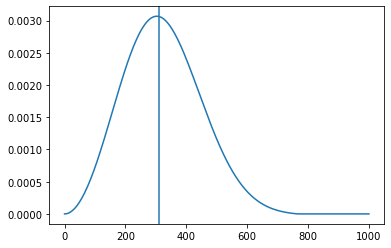

In [2]:
x = np.linspace(0,1000,200) * nu.km / nu.s
y2 = wr.observed_speed_dist(x, 0)
plt.plot(x/(nu.km / nu.s),y2)
plt.axvline(310)

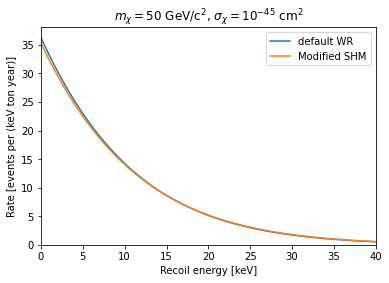

In [3]:
# NR's
energies = np.linspace(0.001, 40, 100)

# dr/dr
dr = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45)

plt.plot(energies, dr, label='default WR')

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 50$ GeV/c${}^2$, $\sigma_\chi = 10^{-45}$ cm${}^2$")
plt.xlim(0, energies.max())
plt.ylim(0, None)

use_SHM = dddm.SHM()
dr_shm = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45, halo_model = use_SHM)
plt.plot(energies, dr_shm, label = "Modified SHM")
plt.legend()

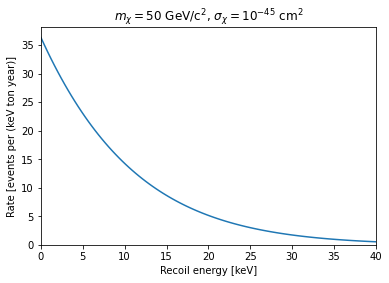

In [11]:
# NR's
energies = np.linspace(0.0001, 40, 100)

# dr/dr
dr = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45)

plt.plot(energies, dr, label='default WR')


plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 50$ GeV/c${}^2$, $\sigma_\chi = 10^{-45}$ cm${}^2$")
plt.xlim(0, energies.max())
plt.ylim(0, None)

try: 
    import verne
except (ImportError, ModuleNotFoundError):
    pass
else:
    use_SHM = dddm.ShieldedSHM(location='XENON')
    dr_shm = wr.rate_wimp_std(energies,
        mw=50, sigma_nucleon=1e-45, halo_model = use_SHM)
    plt.plot(energies, dr_shm, label = "verne SHM")
    plt.legend()

In [86]:
# NR's
energies = np.linspace(0.1, 10, 100)

# dr/dr
dr = wr.rate_migdal(energies* nu.keV, 
                    mw=5 * nu.GeV / nu.c0 ** 2, 
                    material='Ge',
                    sigma_nucleon=1e-40 * nu.cm ** 2) * (nu.keV * (1000 * nu.kg) * nu.year)
# dr = wr.rate_wimp_std(energies, mw=5, sigma_nucleon=1e-40, material='Ge')

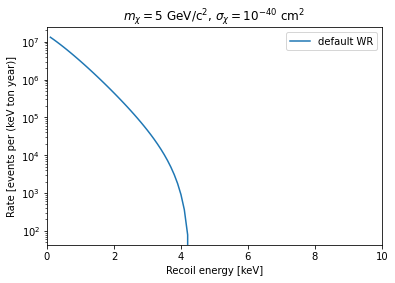

In [52]:
plt.plot(energies, dr, label='default WR')


plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 5$ GeV/c${}^2$, $\sigma_\chi = 10^{-40}$ cm${}^2$")
plt.xlim(0, energies.max())
# plt.ylim(0, dr.max());

plt.yscale('log')
plt.legend()

In [138]:
import darkelf

In [139]:
from darkelf import targets
targets.files('Ge')

Available configuration files: 
	 Ge.yaml
 
Available data for epsilon: 
	 Ge_gpaw_withLFE.dat
	 Ge_Migdal_FAC.dat
	 Ge_epsphonon_data2K.dat
	 Ge_gpaw_noLFE.dat
	 Ge_epsphonon_theory6K.dat
	 Ge_mermin.dat
 
Available data for phonon (partial) density of states: 
	 Ge_DoS.dat
 
Available data for Fn(omega) functions: 
	 Ge_Fn.dat
 
Available data for form factors: 
	 Ge_atomic_Zion.dat
	 Ge_Zion.dat


In [259]:
Ge_gpaw = darkelf.darkelf(target='Ge',mX=1e8,filename="Ge_gpaw_withLFE.dat")
Ge_gpaw.update_params(mediator='massive',)
Ge_gpaw.rhoX=0.3e9


 .... Loading files for Ge
Loaded Ge_gpaw_withLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method,Journal of Physics:Condensed Matter22(2010) 253202.
phonon ELF taken or calculated from M. Ikezawa and T. Nanba, Two-Phonon Difference Absorption Spectra in Ge Crystals, Journal of  the Physical Society of Japan 45 (1978) 148.
Loaded Ge_epsphonon_data2K.dat for epsilon in phonon regime
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
Loaded Ge_atomic_Zion.dat for dark photon couplings
Loaded Ge_DoS.dat for density of states
Loaded Fn(omega) functions cor

In [283]:
dr2 = Ge_gpaw.dRdomega_migdal(energies*1000, method="grid", approximation="free",fast=1)*1e6

In [284]:
dr2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [285]:
Ge_gpaw.dPdomega??

In [286]:
Ge_gpaw.vesc, Ge_gpaw.veavg

(0.0016678204759907602, 0.0008005538284755649)

In [287]:
wr.rate_wimp_std??

In [288]:
# # # dr2=Ge_gpaw.dRdEn_nuclear(energies*1000)
# dr2 = (Ge_gpaw.dRdomega_migdal(
#         energies*1000,
#         sigma_n=1e-40,
#         method='ibe',
#         Nshell=3,
#         Enth=0.1,
#         Zionkdependence=False,
#     )-Ge_gpaw.dRdomega_migdal(
#         energies*1000,
#         sigma_n=1e-40,
#         method='ibe',
#         Nshell=2,
#         Enth=0.1,
#         Zionkdependence=False,
#     ))*1e6
# #              ], axis=0)
# # dr2=dr2*1e6

In [280]:
Ge_gpaw.dRdomega_migdal??

In [291]:
energies = np.linspace(0, 100) # ev

In [292]:
dr = wr.rate_migdal(energies* nu.keV/1e3, 
                    mw=0.1 * nu.GeV / nu.c0 ** 2, 
                    material='Ge',
                    sigma_nucleon=1e-38 * nu.cm ** 2) * (nu.keV * (1000 * nu.kg) * nu.year)

In [347]:

dr2 = (Ge_gpaw.dRdomega_migdal(
        energies,
        sigma_n=1e-38,
        method='ibe',
        Nshell=6,
#         Enth=0.1,
        Zionkdependence=False,
    ))*1e6
#              ], axis=0)
# dr2=dr2*1e6

In [355]:
wr.StandardHaloModel??

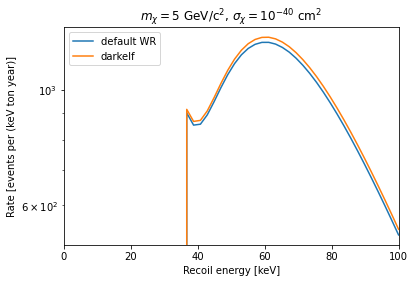

In [361]:
plt.plot(energies, dr*3.1415, label='default WR')
plt.plot(energies, dr2, label='darkelf')

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 5$ GeV/c${}^2$, $\sigma_\chi = 10^{-40}$ cm${}^2$")
plt.xlim(0, energies.max())
# plt.ylim(0, dr.max());

plt.yscale('log')
plt.legend()

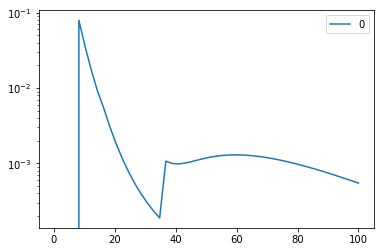

/tmp/ipykernel_512/443535765.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


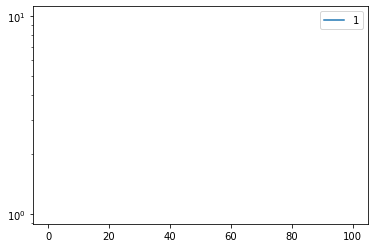

/tmp/ipykernel_512/443535765.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


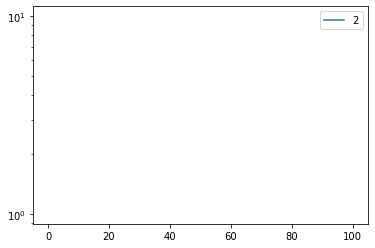

/tmp/ipykernel_512/443535765.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


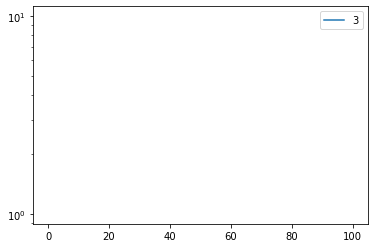

/tmp/ipykernel_512/443535765.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


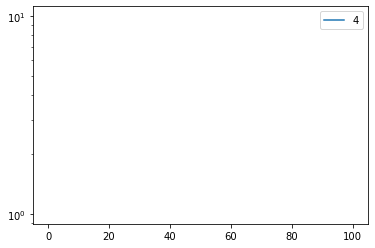

/tmp/ipykernel_512/443535765.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


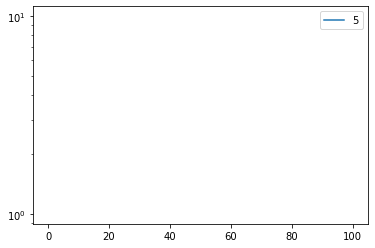

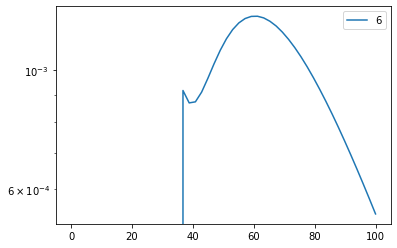

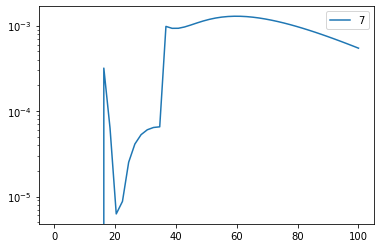

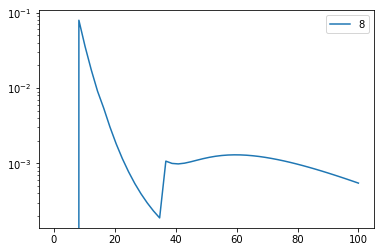

In [344]:
for k in range(9):
    dr2 = Ge_gpaw.dRdomega_migdal(
        energies,
        sigma_n=1e-38,
        method='ibe',
        Nshell=k,
#         Enth=0.1,
        Zionkdependence=False,
    )
    plt.plot(energies, dr2, label=k)
    plt.legend()
    plt.yscale('log')
    plt.show()

In [282]:
Ge_gpaw.dRdomega_migdal??

In [112]:
Ge_gpaw.dRdomega_migdal??

In [ ]:
# NR's
energies = np.linspace(0.1, 10, 100)

# dr/dr
dr = wr.rate_migdal(energies* nu.keV, 
                    mw=5 * nu.GeV / nu.c0 ** 2, 
                    material='Ge',
                    sigma_nucleon=1e-40 * nu.cm ** 2) * (nu.keV * (1000 * nu.kg) * nu.year)
# dr = wr.rate_wimp_std(energies, mw=5, sigma_nucleon=1e-40, material='Ge')

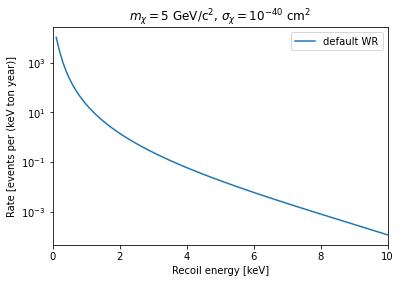

In [6]:
plt.plot(energies, dr, label='default WR')


plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 5$ GeV/c${}^2$, $\sigma_\chi = 10^{-40}$ cm${}^2$")
plt.xlim(0, energies.max())
# plt.ylim(0, dr.max());

plt.yscale('log')
plt.legend()